# Data Importing

In [ ]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [ ]:
# Upload kaggle API key file
data = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the dataset from kaggle
!kaggle datasets download -d luisblanche/covidct

 85% 73.0M/85.8M [00:00<00:00, 69.7MB/s]
100% 85.8M/85.8M [00:00<00:00, 104MB/s] 


In [ ]:
# Extract zipfile
import zipfile
zip_ref = zipfile.ZipFile('covidct.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [ ]:
# Modules for train-val split
import os
import numpy as np
import random
import argparse
from shutil import copyfile

In [ ]:
# Train-val split function
def img_train_test_split(img_source_dir, train_size):
    """
    Randomly splits images over a train and validation folder, while preserving the folder structure
    
    Parameters
    ----------
    img_source_dir : string
        Path to the folder with the images to be split. Can be absolute or relative path   
        
    train_size : float
        Proportion of the original images that need to be copied in the subdirectory in the train folder
    """    
    if not (isinstance(img_source_dir, str)):
        raise AttributeError('img_source_dir must be a string')
        
    if not os.path.exists(img_source_dir):
        raise OSError('img_source_dir does not exist')
        
    if not (isinstance(train_size, float)):
        raise AttributeError('train_size must be a float')
        
    # Set up empty folder structure if not exists
    if not os.path.exists('data'):
        os.makedirs('data')
    else:
        if not os.path.exists('data/train'):
            os.makedirs('data/train')
        if not os.path.exists('data/validation'):
            os.makedirs('data/validation')
            
    # Get the subdirectories in the main image folder
    subdirs = [subdir for subdir in os.listdir(img_source_dir) if os.path.isdir(os.path.join(img_source_dir, subdir))]

    for subdir in subdirs:
        subdir_fullpath = os.path.join(img_source_dir, subdir)
        if len(os.listdir(subdir_fullpath)) == 0:
            print(subdir_fullpath + ' is empty')
            break

        train_subdir = os.path.join('data/train', subdir)
        validation_subdir = os.path.join('data/validation', subdir)

        # Create subdirectories in train and validation folders
        if not os.path.exists(train_subdir):
            os.makedirs(train_subdir)

        if not os.path.exists(validation_subdir):
            os.makedirs(validation_subdir)

        train_counter = 0
        validation_counter = 0

        # Randomly assign an image to train or validation folder
        for filename in os.listdir(subdir_fullpath):
            if filename.endswith(".jpg") or filename.endswith(".png"): 
                fileparts = filename.split('.')

                if random.uniform(0, 1) <= train_size:
                    copyfile(os.path.join(subdir_fullpath, filename), os.path.join(train_subdir, str(train_counter) + '.' + fileparts[1]))
                    train_counter += 1
                else:
                    copyfile(os.path.join(subdir_fullpath, filename), os.path.join(validation_subdir, str(validation_counter) + '.' + fileparts[1]))
                    validation_counter += 1
                    
        print('Copied ' + str(train_counter) + ' images to data/train/' + subdir)
        print('Copied ' + str(validation_counter) + ' images to data/validation/' + subdir)

In [ ]:
# Run the split function
img_train_test_split('/content/files',0.7)

Copied 283 images to data/train/CT_NonCOVID
Copied 114 images to data/validation/CT_NonCOVID
Copied 238 images to data/train/CT_COVID
Copied 111 images to data/validation/CT_COVID


In [ ]:
!pip install -q pyyaml h5py

# Baseline Model

In [ ]:
# Modules for model creation
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
# Create the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',Precision(),Recall()])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 78400)             0

In [ ]:
# Label generator
TRAINING_DIR = "/content/data/train/"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=10,
                                                    class_mode='binary',
                                                    target_size=(300, 300))

VALIDATION_DIR = "/content/data/validation/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=10,
                                                              class_mode='binary',
                                                              target_size=(300, 300))

Found 322 images belonging to 2 classes.
Found 130 images belonging to 2 classes.


In [ ]:
# Fit the model
history = model.fit(train_generator,
                              epochs=100,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/100
33/33 [==============================] - 3s 100ms/step - loss: 1.2721 - accuracy: 0.8354 - precision: 0.8758 - recall: 0.9470 - val_loss: 0.3606 - val_accuracy: 0.8769 - val_precision: 0.8769 - val_recall: 1.0000
Epoch 2/100
33/33 [==============================] - 3s 84ms/step - loss: 0.3287 - accuracy: 0.8789 - precision: 0.8789 - recall: 1.0000 - val_loss: 0.3519 - val_accuracy: 0.8769 - val_precision: 0.8769 - val_recall: 1.0000
Epoch 3/100
33/33 [==============================] - 3s 81ms/step - loss: 0.2190 - accuracy: 0.9255 - precision: 0.9246 - recall: 0.9965 - val_loss: 0.3142 - val_accuracy: 0.8846 - val_precision: 0.8837 - val_recall: 1.0000
Epoch 4/100
33/33 [==============================] - 3s 82ms/step - loss: 0.1720 - accuracy: 0.9441 - precision: 0.9522 - recall: 0.9859 - val_loss: 0.3363 - val_accuracy: 0.9000 - val_precision: 0.8976 - val_recall: 1.0000
Epoch 5/100
33/33 [==============================] - 3s 81ms/step - loss: 0.1018 - accuracy: 0.9565 - p

<Figure size 432x288 with 0 Axes>

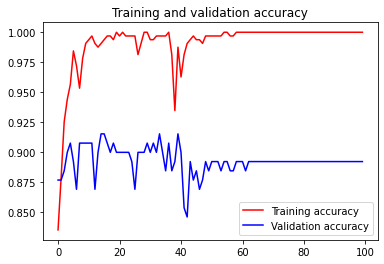

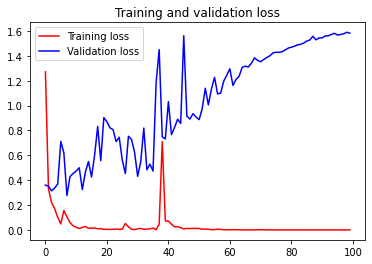

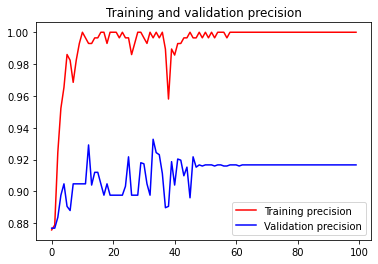

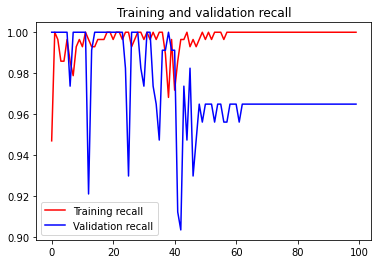

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
pre=history.history['precision']
val_pre=history.history['val_precision']
rec=history.history['recall']
val_rec=history.history['val_recall']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label ='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation precision per epoch
#------------------------------------------------
plt.plot(epochs, pre, 'r', label = 'Training precision')
plt.plot(epochs, val_pre, 'b', label ='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation recall per epoch
#------------------------------------------------
plt.plot(epochs, rec, 'r', label = 'Training recall')
plt.plot(epochs, val_rec, 'b', label = 'Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.figure()

In [ ]:
model.save('baseline.h5')

#Transfer Learning

In [ ]:
from tensorflow.keras.applications import MobileNetV2, InceptionV3, VGG16, VGG19, ResNet50, InceptionResNetV2

##MobileNetV2

In [ ]:
mobile_model=MobileNetV2(input_shape=(300,300,3),include_top=False)

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
mobile_model.trainable=False

In [ ]:
mobile_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 301, 301, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 150, 150, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 150, 150, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
last_output=mobile_model.output
print('last layer output shape: ', mobile_model.output_shape)

last layer output shape:  (None, 10, 10, 1280)


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model

In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.1)(x)                  
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(mobile_model.input, x) 
model.summary

<bound method Network.summary of <tensorflow.python.keras.engine.training.Model object at 0x7fc1d40172e8>>

In [ ]:
model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy',Precision(),Recall()])

In [ ]:
# Fit the model
history = model.fit(train_generator,
                              epochs=100,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/100
33/33 [==============================] - 5s 149ms/step - loss: 9.4103 - accuracy: 0.8323 - precision_1: 0.9018 - recall_1: 0.9081 - val_loss: 8.8377 - val_accuracy: 0.7538 - val_precision_1: 0.9767 - val_recall_1: 0.7368
Epoch 2/100
33/33 [==============================] - 4s 109ms/step - loss: 4.2670 - accuracy: 0.9286 - precision_1: 0.9676 - recall_1: 0.9505 - val_loss: 5.4037 - val_accuracy: 0.9308 - val_precision_1: 0.9339 - val_recall_1: 0.9912
Epoch 3/100
33/33 [==============================] - 4s 109ms/step - loss: 0.7981 - accuracy: 0.9783 - precision_1: 0.9859 - recall_1: 0.9894 - val_loss: 6.1214 - val_accuracy: 0.9308 - val_precision_1: 0.9339 - val_recall_1: 0.9912
Epoch 4/100
33/33 [==============================] - 4s 110ms/step - loss: 0.3764 - accuracy: 0.9783 - precision_1: 0.9894 - recall_1: 0.9859 - val_loss: 3.9695 - val_accuracy: 0.9385 - val_precision_1: 0.9649 - val_recall_1: 0.9649
Epoch 5/100
33/33 [==============================] - 4s 109ms/step -

<Figure size 432x288 with 0 Axes>

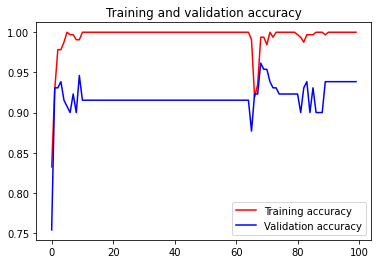

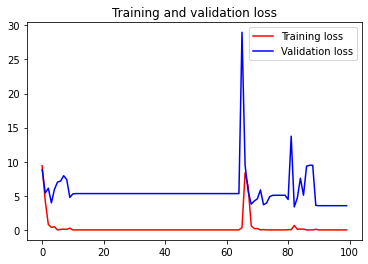

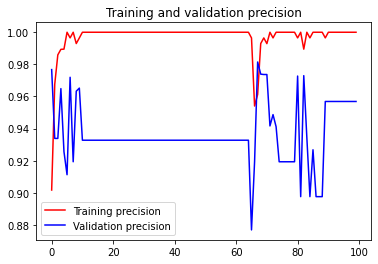

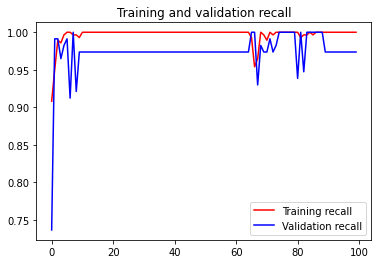

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
pre=history.history['precision_1']
val_pre=history.history['val_precision_1']
rec=history.history['recall_1']
val_rec=history.history['val_recall_1']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label ='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation precision per epoch
#------------------------------------------------
plt.plot(epochs, pre, 'r', label = 'Training precision')
plt.plot(epochs, val_pre, 'b', label ='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation recall per epoch
#------------------------------------------------
plt.plot(epochs, rec, 'r', label = 'Training recall')
plt.plot(epochs, val_rec, 'b', label = 'Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.figure()

In [ ]:
model.save('mobiletrans.h5')

##InceptionV3

In [ ]:
incept_model=InceptionV3(input_shape=(300,300,3),include_top=False)

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
incept_model.trainable=False

In [ ]:
incept_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
last_output=incept_model.output
print('last layer output shape: ', incept_model.output_shape)

last layer output shape:  (None, 8, 8, 2048)


In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.1)(x)                  
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(incept_model.input, x) 
model.summary

<bound method Network.summary of <tensorflow.python.keras.engine.training.Model object at 0x7fc1d07bda58>>

In [ ]:
model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy',Precision(),Recall()])

In [ ]:
# Fit the model
history = model.fit(train_generator,
                              epochs=100,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/100
33/33 [==============================] - 9s 275ms/step - loss: 12.7780 - accuracy: 0.8230 - precision_2: 0.9007 - recall_2: 0.8975 - val_loss: 2.1717 - val_accuracy: 0.8769 - val_precision_2: 0.9298 - val_recall_2: 0.9298
Epoch 2/100
33/33 [==============================] - 6s 196ms/step - loss: 0.7338 - accuracy: 0.9565 - precision_2: 0.9753 - recall_2: 0.9753 - val_loss: 4.2662 - val_accuracy: 0.9077 - val_precision_2: 0.9048 - val_recall_2: 1.0000
Epoch 3/100
33/33 [==============================] - 6s 197ms/step - loss: 0.6972 - accuracy: 0.9720 - precision_2: 0.9858 - recall_2: 0.9823 - val_loss: 6.3558 - val_accuracy: 0.8846 - val_precision_2: 0.8837 - val_recall_2: 1.0000
Epoch 4/100
33/33 [==============================] - 7s 197ms/step - loss: 0.1019 - accuracy: 0.9814 - precision_2: 0.9894 - recall_2: 0.9894 - val_loss: 7.5381 - val_accuracy: 0.8769 - val_precision_2: 0.8769 - val_recall_2: 1.0000
Epoch 5/100
33/33 [==============================] - 7s 197ms/step 

<Figure size 432x288 with 0 Axes>

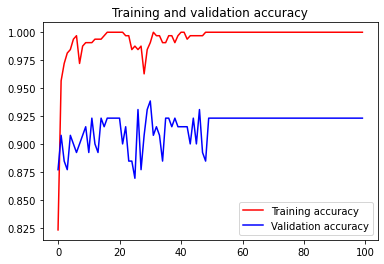

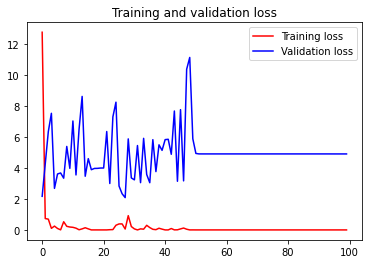

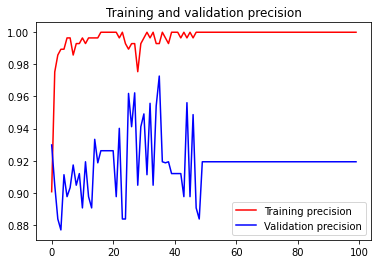

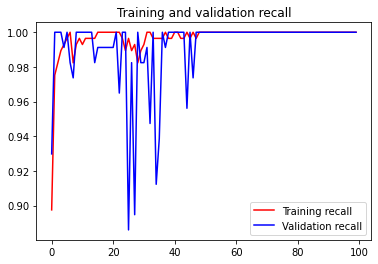

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
pre=history.history['precision_2']
val_pre=history.history['val_precision_2']
rec=history.history['recall_2']
val_rec=history.history['val_recall_2']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label ='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation precision per epoch
#------------------------------------------------
plt.plot(epochs, pre, 'r', label = 'Training precision')
plt.plot(epochs, val_pre, 'b', label ='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation recall per epoch
#------------------------------------------------
plt.plot(epochs, rec, 'r', label = 'Training recall')
plt.plot(epochs, val_rec, 'b', label = 'Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.figure()

In [ ]:
model.save('Inceptrans.h5')

##VGG19

In [ ]:
vgg19_model=VGG19(input_shape=(300,300,3),include_top=False)

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
vgg19_model.trainable=False

In [ ]:
vgg19_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [ ]:
last_output=vgg19_model.output
print('last layer output shape: ', vgg19_model.output_shape)

last layer output shape:  (None, 9, 9, 512)


In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.1)(x)                  
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(vgg19_model.input, x) 
model.summary

<bound method Network.summary of <tensorflow.python.keras.engine.training.Model object at 0x7fc1cba14240>>

In [ ]:
model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy',Precision(),Recall()])

In [ ]:
# Fit the model
history = model.fit(train_generator,
                              epochs=100,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/100
33/33 [==============================] - 14s 410ms/step - loss: 2.2071 - accuracy: 0.8323 - precision_4: 0.8990 - recall_4: 0.9117 - val_loss: 0.8971 - val_accuracy: 0.6769 - val_precision_4: 1.0000 - val_recall_4: 0.6316
Epoch 2/100
33/33 [==============================] - 13s 397ms/step - loss: 0.4897 - accuracy: 0.8696 - precision_4: 0.9170 - recall_4: 0.9364 - val_loss: 0.3410 - val_accuracy: 0.8462 - val_precision_4: 0.9519 - val_recall_4: 0.8684
Epoch 3/100
33/33 [==============================] - 13s 396ms/step - loss: 0.1668 - accuracy: 0.9503 - precision_4: 0.9684 - recall_4: 0.9753 - val_loss: 0.4501 - val_accuracy: 0.9077 - val_precision_4: 0.9048 - val_recall_4: 1.0000
Epoch 4/100
33/33 [==============================] - 13s 395ms/step - loss: 0.1664 - accuracy: 0.9410 - precision_4: 0.9615 - recall_4: 0.9717 - val_loss: 0.2850 - val_accuracy: 0.9462 - val_precision_4: 0.9421 - val_recall_4: 1.0000
Epoch 5/100
33/33 [==============================] - 13s 397ms/s

<Figure size 432x288 with 0 Axes>

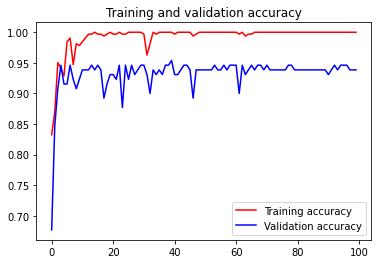

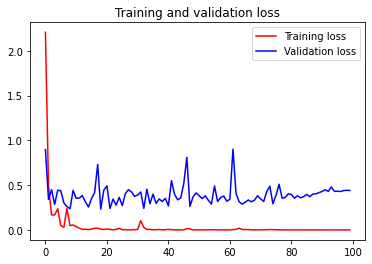

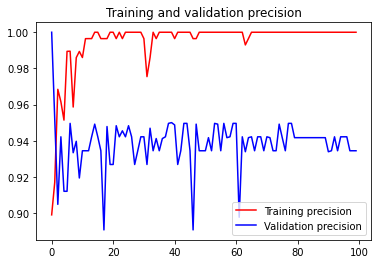

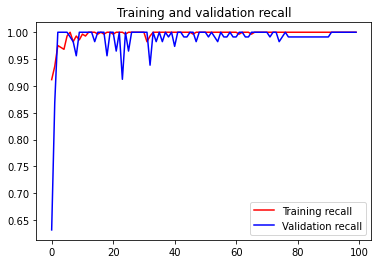

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
pre=history.history['precision_4']
val_pre=history.history['val_precision_4']
rec=history.history['recall_4']
val_rec=history.history['val_recall_4']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label ='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation precision per epoch
#------------------------------------------------
plt.plot(epochs, pre, 'r', label = 'Training precision')
plt.plot(epochs, val_pre, 'b', label ='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation recall per epoch
#------------------------------------------------
plt.plot(epochs, rec, 'r', label = 'Training recall')
plt.plot(epochs, val_rec, 'b', label = 'Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.figure()

In [ ]:
model.save('VGG19trans.h5')